In [1]:
import numpy as np
from gensim import corpora, models
import gensim
import csv
from sklearn.externals import joblib
import bz2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import pickle

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

%pylab inline
# %matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time 

# dataset = 'karbala'
dataset = 'all'

corpus_dictionary_file = 'data/eos/ngram/bigram_dict_'+dataset+'.dict'
corpus_doc2bow_file = 'data/eos/ngram/bigram_bow_corpus_'+dataset+'.mm'

# Load to memory
corpus = gensim.corpora.MmCorpus(corpus_doc2bow_file)
dictionary = gensim.corpora.Dictionary.load(corpus_dictionary_file)
# ldamodel = joblib.load('data/eos/lda/16_LDAmodel_EOS.pkl')

print(corpus)
print(dictionary)
# print(ldamodel)



2017-07-03 01:01:32,977 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_all.mm.index
2017-07-03 01:01:32,978 : INFO : initializing corpus reader from data/eos/ngram/bigram_bow_corpus_all.mm
2017-07-03 01:01:32,979 : INFO : accepted corpus with 460187 documents, 100000 features, 86073196 non-zero entries
2017-07-03 01:01:32,979 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_all.dict
2017-07-03 01:01:33,014 : INFO : loaded data/eos/ngram/bigram_dict_all.dict


MmCorpus(460187 documents, 100000 features, 86073196 non-zero entries)
Dictionary(100000 unique tokens: ['presto', 'charleston_west', 'schmidt', 'joni_mitchell', 'janice']...)
CPU times: user 64 ms, sys: 16 ms, total: 80 ms
Wall time: 78.3 ms


In [14]:
%%time

def get_colors(ldamodel):
    color = []
    logging.info("starting colors")
    for corpus_line in corpus:
        sorted_topic_line = list(sorted(ldamodel[corpus_line], key=lambda x: x[1], reverse=True))
        color.append(sorted_topic_line[0][0])

    with open('data/eos/pca_color.p', 'wb') as fp:
        pickle.dump(color, fp)    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [15]:
%%time

def get_lda_out(ldamodel):
    lda_output = []
    for line in corpus:
        lda_output.append(ldamodel[line])

    with open('data/eos/pca_lda_output.p', 'wb') as fp:
        pickle.dump(lda_output, fp)  

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [3]:
%%time

topic_model = 'data/eos/lda/20_LDAmodel_EOS.pkl'
ldamodel = joblib.load(topic_model)
print(ldamodel)

LdaModel(num_terms=100000, num_topics=20, decay=0.5, chunksize=2000)
CPU times: user 664 ms, sys: 24 ms, total: 688 ms
Wall time: 691 ms


In [21]:
%%time


get_colors(ldamodel)
get_lda_out(ldamodel)


2017-07-02 23:38:15,246 : INFO : starting colors


CPU times: user 1h 5min 4s, sys: 3h 9min 33s, total: 4h 14min 38s
Wall time: 39min 47s


In [4]:
%%time


color = pickle.load( open('data/eos/pca_color.p', "rb") )
lda_output = pickle.load( open('data/eos/pca_lda_output.p', "rb") )
print(len(lda_output))

topic_num = 20
topics_data = np.zeros(shape=(len(corpus), topic_num))


for i, line in enumerate(lda_output):
    for topic_line in line:
        topics_data[i][topic_line[0]] = topic_line[1]

460187
CPU times: user 1.49 s, sys: 96 ms, total: 1.59 s
Wall time: 1.59 s


Populating the interactive namespace from numpy and matplotlib
CPU times: user 1.76 s, sys: 532 ms, total: 2.29 s
Wall time: 1.17 s


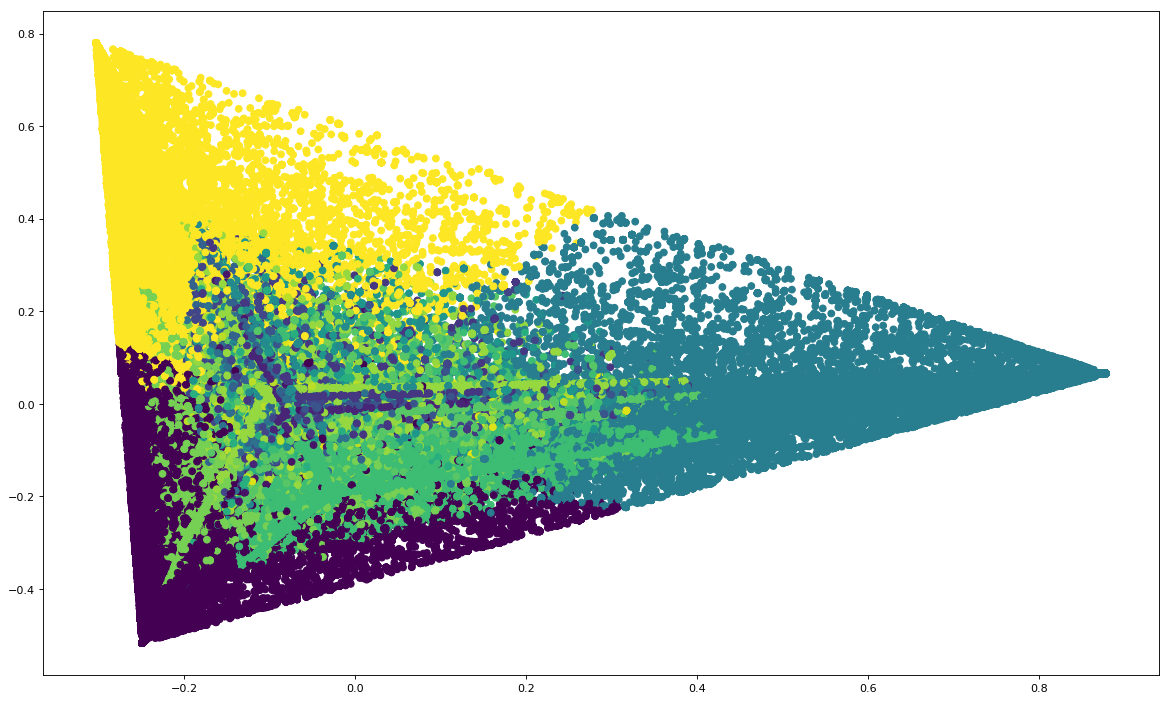

In [5]:
%%time


X_pca = PCA().fit_transform(topics_data)
figure(num=None, figsize=(18, 11), dpi=80, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)

In [ ]:
%%time


topics_data_norm  = stats.zscore(topics_data, axis=0)

X_pca = PCA().fit_transform(topics_data_norm )
figure(num=None, figsize=(18, 11), dpi=800, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)

CPU times: user 1.87 s, sys: 556 ms, total: 2.42 s
Wall time: 1.31 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [27]:
%%time

topics_data = np.zeros(shape=(len(corpus) * 2, 10))

print (topics_data.shape)
print(len(lda_output))

for i, line in enumerate(lda_output):
    for topic_line in line:
            topics_data[i][topic_line[0]] = topic_line[1]
         
topics_data_norm = stats.zscore(topics_data, axis=0)

print(topics_data_norm.shape)

color = []
for line in topics_data_norm:
    color_number =[i for i, j in enumerate(line) if j == max(line)]
    color.append(int(color_number[0]))

X_pca = PCA().fit_transform(topics_data_norm )
figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)



(920374, 10)
460187


IndexError: index 12 is out of bounds for axis 0 with size 10

In [ ]:
%%time 


from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(topics_data_norm)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(topics_data_norm, labels))

In [ ]:
%%time

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_digits = 8
reduced_data = PCA(n_components=2).fit_transform(topics_data_norm)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

print ("finished kmeans clustering")
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
%%time


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# TSNE

In [ ]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')


# doc_topic_distr = ldamodel.fit_transform()
# 20-D -> 2-D
# tsne_lda = tsne_model.fit_transform(doc_topic_distr)
